In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cufflinks as cf
# Modo offline para rodar os graficos apenas na máquina e não na nuvem
cf.go_offline()
import random
import seaborn as sns
import pandas as pd
import numpy as np
import time
import turicreate as tc
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys
import warnings
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys, os
from contextlib import contextmanager
from scipy.spatial.distance import pdist, squareform


#from lightfm.cross_validation import random_train_test_split
#from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
#from lightfm import LightFM
#from skopt import forest_minimize
from tqdm import tqdm
from gensim.models import Word2Vec 

warnings.filterwarnings('ignore')
%matplotlib inline

In [160]:
! pip install gensim

    100% |################################| 24.2MB 58kB/s eta 0:00:011    95% |##############################  | 23.1MB 795kB/s eta 0:00:02
    100% |################################| 112kB 802kB/s ta 0:00:01
    100% |################################| 133kB 671kB/s ta 0:00:01
    100% |################################| 6.1MB 216kB/s ta 0:00:011
    100% |################################| 71kB 675kB/s ta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/clayton/.cache/pip/wheels/51/88/6c/2bcd305b87c1e62cbcbf419e782ad9fc612cd4bbb71557502d
Successfully built smart-open


In [2]:
df = pd.read_csv('../data/barcode.csv', sep=',')
df.head(10)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
0,11260,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
2,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
3,7471,7927,1036,Café Torrado e Moído a Vácuo 3 Corações Estrad...,303,Café,214,Pai - Mercearia Básica
4,4270,7927,4785,Sabonete em Barra Creme e Flor de Peônia Dove ...,195,Sabonete em Barra,182,Pai - HPC
5,5434,7927,5391,Tomate Pelado em Cubos La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
6,9991,7927,5391,Tomate Pelado em Cubos La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
7,5434,7927,5391,Tomate Pelado em Cubos La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
8,5434,7927,5391,Tomate Pelado La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
9,9991,7927,5391,Tomate Pelado La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar


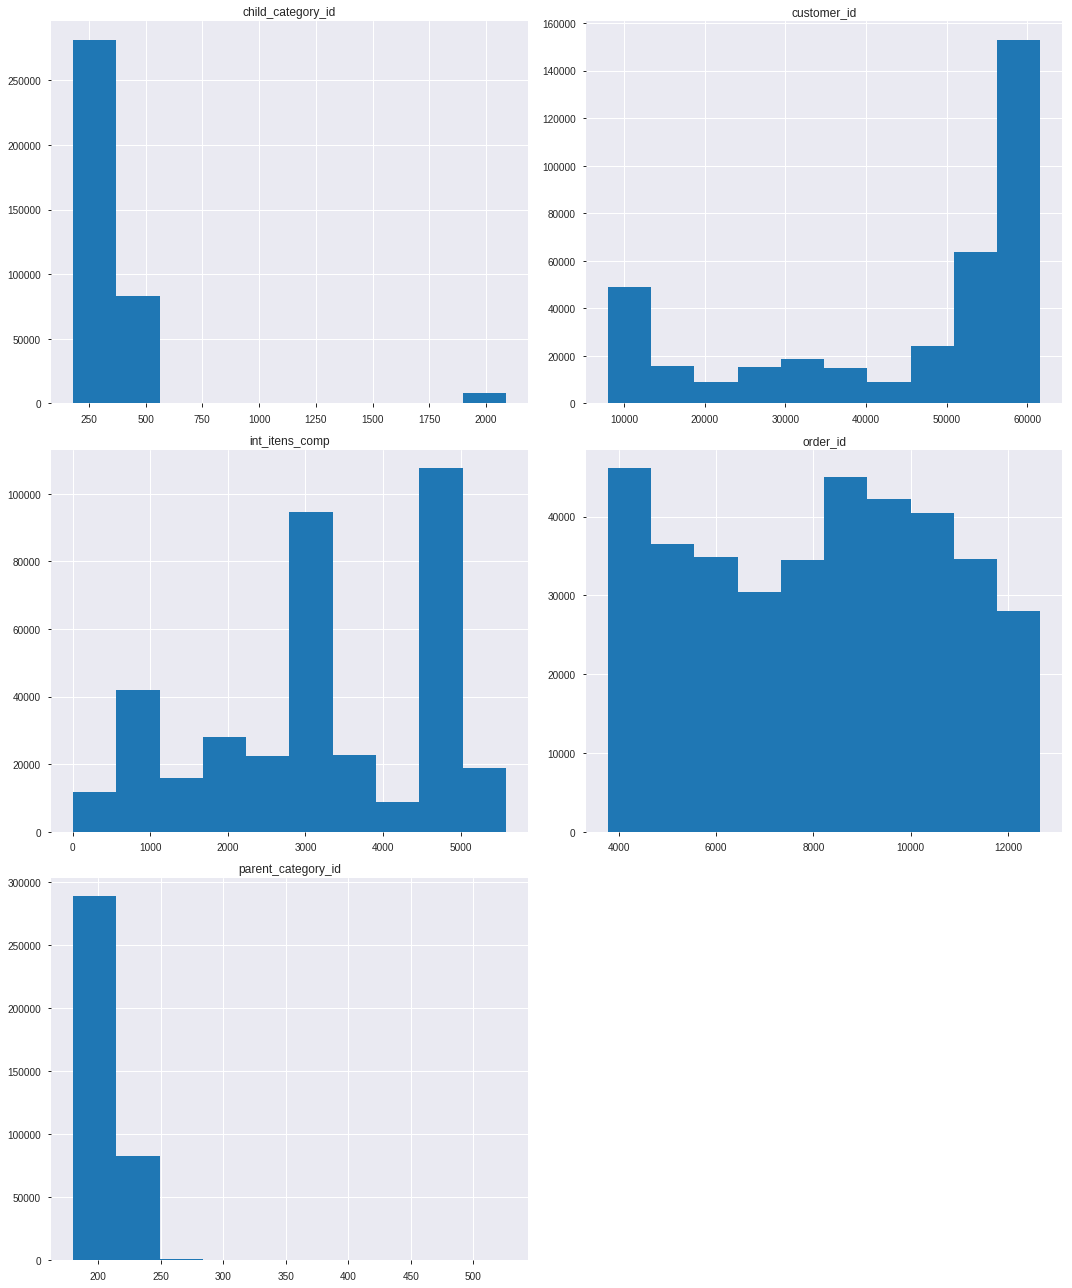

In [5]:
#Verificar distribuição dos dados
df.hist(figsize=(15,18))

plt.tight_layout()
plt.show()

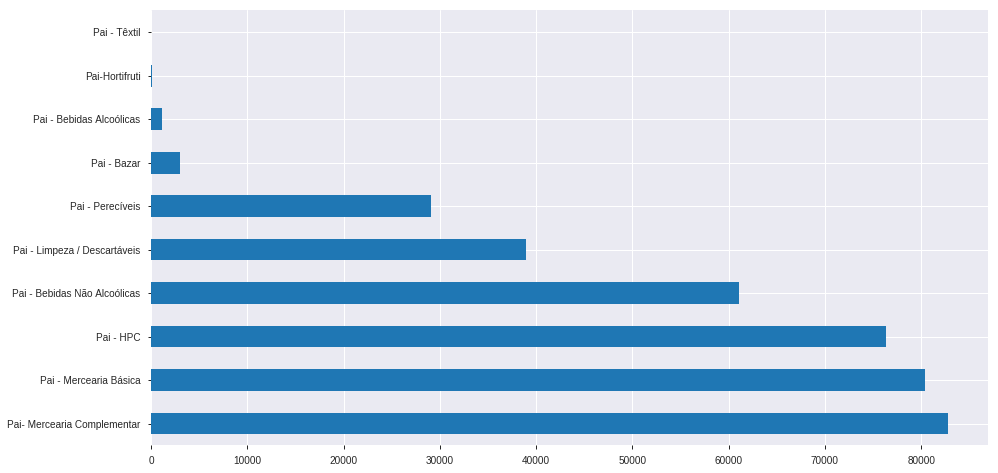

In [6]:
pai = df.parent_category_name.value_counts().plot(kind='barh',figsize=(15,8))
plt.show(pai)

In [7]:
# Quantidade de clusteres por categoria Pai

df.parent_category_name.value_counts()

Pai- Mercearia Complementar     82782
Pai - Mercearia Básica          80435
Pai - HPC                       76372
Pai - Bebidas Não Alcoólicas    61084
Pai - Limpeza / Descartáveis    38999
Pai - Perecíveis                29060
Pai - Bazar                      2987
Pai - Bebidas Alcoólicas         1139
Pai-Hortifruti                    120
Pai - Têxtil                        1
Name: parent_category_name, dtype: int64

In [8]:
# Quantidade de clusteres por categoria Filho

df.child_category_name.value_counts()

Suco                        56091
Sabonete em Barra           45254
Macarrão de Sêmola          32598
Macarrão Instantâneo        18825
Molho de Tomate             12832
                            ...  
Licor                           1
Pano para Pia de Cozinha        1
Coquetel Alcoólico              1
Salsicha                        1
Prato Pronto                    1
Name: child_category_name, Length: 346, dtype: int64

## Filtrando os dados por categorias

    - Podemos observar que temos produtos com apenas uma compra realizada

In [354]:
# quantidade de ítens comprados por cliente
grup = df.groupby(by='customer_id').child_category_name.value_counts()
grup.to_csv('../data/Itensbyclient.csv')
grup

customer_id  child_category_name         
7927         Iogurte                         102
             Macarrão de Sêmola               51
             Sabonete em Barra                48
             Tempero em Tablete               22
             Café                             16
                                            ... 
61661        Odorizador de Ambiente/Roupa     14
             Papel Higiênico                   6
             Esponja Multiuso                  5
             Esponja de Aço                    4
             Água Sanitária                    3
Name: child_category_name, Length: 27535, dtype: int64

In [17]:
# os 10 ítens mais vendidos
mais_vendidos = df['child_category_name'].value_counts()[:10]
mais_vendidos

Suco                    56091
Sabonete em Barra       45254
Macarrão de Sêmola      32598
Macarrão Instantâneo    18825
Molho de Tomate         12832
Leite Tradicional       12188
Creme Dental            10500
Café                     8731
Detergente de Louça      8236
Limpador Multiuso        7905
Name: child_category_name, dtype: int64

In [10]:
# quantidade de ítens comprados por id
df2 = df.groupby(['child_category_name']).agg({'product_name': np.size})
df2

,product_name
child_category_name,
0101 - CERVEJAS,34
Abacaxi em Calda,4
Absorvente Higiênico,831
Achocolatado em Pó,390
Adesivo Instantâneo,47
...,...
Óleo de Canola,35
Óleo de Girassol,97
Óleo de Milho,31


In [24]:
# Quantidade de clientes que efetuaram ao menos uma compra
customers = df["customer_id"].unique().tolist()
customers = np.array(customers)
#customers

In [68]:
# quantidade de ítens vendidos por categoria Pai

filho = pd.crosstab(df['customer_id'],df['child_category_name'])
#filho['Total'] = filho.sum(axis=1)
#filho['Media'] = filho.mean(axis=1)
filho.to_csv('../data/filho.csv')
filho.values

array([[0, 0, 0, ..., 0, 8, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
# Contagem de produtos vendidos por categoria

vendas_categoria = df.groupby(by='child_category_name').product_name.count()
vendas_categoria.head(20)

child_category_name
0101 - CERVEJAS                   34
Abacaxi em Calda                   4
Absorvente Higiênico             831
Achocolatado em Pó               390
Adesivo Instantâneo               47
Adestrador Uso Veterinário         3
Aditivo para Carro                 3
Adoçante                         435
Aguardente                         6
Aipim/Mandioca                     2
Alimento Úmido para Cães         136
Alimento Úmido para Gatos         24
Alvejante                        193
Amaciante de Roupa              1580
Amendoim                         159
Amido                            143
Ampola de Tratamento              37
Aparelho e Lâmina de Barbear    1149
Aparelho e Lâmina de Depilar      87
Aperitivo Bebida                   3
Name: product_name, dtype: int64

In [356]:
prod_menos = vendas_categoria.loc[vendas_categoria.values < 10]
print('Produtos menos vendidos:\n', prod_menos )

Produtos menos vendidos:
 child_category_name
Tempero em Pó e Granulado          9
Whisky                             9
Queijo Brie                        9
Nata                               9
Prendedor de Roupa                 9
Polidor de Sapato                  9
Cola Multiuso                      9
Caneca                             8
Forma para Gelo                    8
Hidratante/Loção Infantil          8
Condicionador Uso Veterinário      8
Prato                              8
Doce de Leite Tablete e Bolinha    8
Patê                               8
Açúcar Mascavo                     8
Mix de Legumes e Vegetais          7
Rodo                               7
Queijo Gouda                       7
Vodka                              7
Rum                                6
Carne Suína                        6
Limpa Forno                        6
Kit Feijoada                       6
Porta-Detergente                   6
Funil                              6
Aguardente                   

In [16]:
prod_mais = vendas_categoria.loc[vendas_categoria.values > 300]
print('Produtos mais vendidos:\n', prod_mais)

Produtos mais vendidos:
 child_category_name
Absorvente Higiênico             831
Achocolatado em Pó               390
Adoçante                         435
Amaciante de Roupa              1580
Aparelho e Lâmina de Barbear    1149
                                ... 
Torrada                         1994
Wafer                           2286
Água Sanitária                  1309
Água de Coco                     354
Óleo de Soja                    1797
Name: product_name, Length: 96, dtype: int64


In [17]:
# Filtrando a categoria com quantidade de vendas > 5
vendas_categoria = vendas_categoria.loc[vendas_categoria.values > 5]
 
# Ordena do maior para o menor
vendas_categoria.sort_values(ascending=False, inplace=True)
vendas_categoria

child_category_name
Suco                    56091
Sabonete em Barra       45254
Macarrão de Sêmola      32598
Macarrão Instantâneo    18825
Molho de Tomate         12832
                        ...  
Funil                       6
Aguardente                  6
Feijão Pronto               6
Escorredor de Talher        6
Limpeza Automotiva          6
Name: product_name, Length: 263, dtype: int64

In [18]:
# Plotando os dados de produtos com suas categorias.
import plotly.offline as py
import plotly.graph_objs as go

In [21]:
# Todos os produtos da categoria filho
trace0 = go.Bar(y=vendas_categoria.values,
               x=vendas_categoria.index,
               marker = {'color': '#00FF2A'},
               orientation='v'
               )

# produtos mais vendidos
trace1 = go.Bar(y=prod_mais.values,
               x=prod_mais.index,
               marker = {'color': '#00FF2A'},
               orientation='v'
               )

# produtos menos vendidos
trace2 = go.Bar(y=prod_menos.values,
               x=prod_menos.index,
               marker = {'color': '#00FF2A'},
               orientation='v'
               )



# Para alterar os plots basta alterar os trace
data = [trace2]


# Criando o Layout
config_layout = go.Layout(title='Vendas por categoria de produtos',
                         xaxis=dict(
                             titlefont=dict(
                                 size=40,
                                 color='lightgrey'),
                         tickangle=75),
                         yaxis={'title':'Quantidade Vendida'})

# Objeto Figura
fig = go.Figure(data=data, layout=config_layout)

# Plotando
py.iplot(fig)

## Divisão por quantidade e clustering

In [199]:
# Declaro o valor de K, a métrica a ser utilizada de forma global
global k,metric

# Valor desejado para k
k=10

# Aqui podemos alterar a métrica a ser utilizada como "correlation" de Pearson
metric='cosine' 

In [64]:
# agrupamento de descricao por id
descricao_por_id = df.groupby(by='customer_id').child_category_name.value_counts()


# exemplo de amostra
descricao_por_id

customer_id  child_category_name         
7927         Iogurte                         102
             Macarrão de Sêmola               51
             Sabonete em Barra                48
             Tempero em Tablete               22
             Café                             16
                                            ... 
61661        Odorizador de Ambiente/Roupa     14
             Papel Higiênico                   6
             Esponja Multiuso                  5
             Esponja de Aço                    4
             Água Sanitária                    3
Name: child_category_name, Length: 27535, dtype: int64

In [66]:
#os itens de cada compra
pred = pd.crosstab(df['customer_id'],df['child_category_name'])
pred = pd.DataFrame(pred)
pred

child_category_name,0101 - CERVEJAS,Abacaxi em Calda,Absorvente Higiênico,Achocolatado em Pó,Adesivo Instantâneo,Adestrador Uso Veterinário,Aditivo para Carro,Adoçante,Aguardente,Aipim/Mandioca,...,Água Micelar,Água Mineral sem Gás,Água Sanitária,Água de Coco,Óleo Composto/Misto,Óleo de Canola,Óleo de Girassol,Óleo de Milho,Óleo de Soja,Óleo para Bebê
customer_id,,,,,,,,,,,,,,,,,,,,,
7927,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,8,0
7952,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,2,0
8037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8086,0,1,1,0,1,0,0,0,0,0,...,0,0,2,4,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61625,0,0,15,7,0,0,0,0,0,0,...,0,0,0,0,2,1,1,0,3,0
61631,0,0,1,0,0,0,0,2,0,0,...,0,0,5,0,6,0,0,0,12,0
61640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# analisando a correlação dos produtos
correlation = pred.corr()
correlation

child_category_name,0101 - CERVEJAS,Abacaxi em Calda,Absorvente Higiênico,Achocolatado em Pó,Adesivo Instantâneo,Adestrador Uso Veterinário,Aditivo para Carro,Adoçante,Aguardente,Aipim/Mandioca,...,Água Micelar,Água Mineral sem Gás,Água Sanitária,Água de Coco,Óleo Composto/Misto,Óleo de Canola,Óleo de Girassol,Óleo de Milho,Óleo de Soja,Óleo para Bebê
child_category_name,,,,,,,,,,,,,,,,,,,,,
0101 - CERVEJAS,1.000000,-0.002869,-0.009340,0.009102,0.018199,-0.003932,-0.003044,-0.004325,-0.004309,-0.003209,...,-0.002268,0.000350,0.070466,0.010049,0.062431,0.051112,-0.004736,-0.008061,0.000798,0.018697
Abacaxi em Calda,-0.002869,1.000000,-0.009184,-0.014117,0.032914,-0.002382,-0.001844,-0.008338,-0.002610,-0.001944,...,-0.001374,-0.003998,-0.014554,0.006393,-0.012926,-0.004589,-0.006508,-0.004884,-0.009006,-0.003941
Absorvente Higiênico,-0.009340,-0.009184,1.000000,0.262060,0.067860,0.001907,0.041366,0.046792,-0.019085,-0.014213,...,0.012245,0.030909,0.289201,0.006660,0.101086,0.019628,0.050387,0.001354,0.110161,0.044264
Achocolatado em Pó,0.009102,-0.014117,0.262060,1.000000,0.141595,0.072122,0.008626,0.109659,-0.012846,-0.015786,...,0.041594,0.083780,0.255133,0.092758,0.155725,0.096145,0.132640,0.123671,0.149168,0.119331
Adesivo Instantâneo,0.018199,0.032914,0.067860,0.141595,1.000000,-0.011552,-0.008943,0.178383,-0.012659,-0.009427,...,-0.006663,0.058155,0.206174,0.062057,0.065669,0.127428,0.038652,-0.008697,0.196226,-0.019114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Óleo de Canola,0.051112,-0.004589,0.019628,0.096145,0.127428,-0.006289,-0.004868,0.007314,-0.006891,-0.005132,...,-0.003627,-0.002456,0.017079,0.467740,0.005223,1.000000,0.197458,0.074758,0.052814,-0.010405
Óleo de Girassol,-0.004736,-0.006508,0.050387,0.132640,0.038652,0.019339,-0.006904,0.053367,0.021192,-0.007278,...,0.043748,0.206038,0.094846,0.045567,0.032145,0.197458,1.000000,0.228412,0.053825,0.195643
Óleo de Milho,-0.008061,-0.004884,0.001354,0.123671,-0.008697,-0.006693,-0.005181,0.023023,-0.007334,-0.005462,...,-0.003860,0.037419,0.058784,0.010438,0.029146,0.074758,0.228412,1.000000,0.014261,0.177131


In [68]:
# maiores correlações tirando as duplicatas
maiores_corrs = correlation.unstack().sort_values(ascending=False)[346:]
maiores_corrs

child_category_name      child_category_name    
Detergente Multiuso      Detergente Multiuso        1.000000
Desodorizador Sanitário  Desodorizador Sanitário    1.000000
Desodorante para Pés     Desodorante para Pés       1.000000
Desodorante Spray        Desodorante Spray          1.000000
Desodorante Roll-On      Desodorante Roll-On        1.000000
                                                      ...   
Mostarda                 Escova Multiuso           -0.036160
Porta-Mantimentos        Esponja de Aço            -0.036164
Esponja de Aço           Porta-Mantimentos         -0.036164
Goiabada                 Macarrão Instantâneo      -0.042197
Macarrão Instantâneo     Goiabada                  -0.042197
Length: 119370, dtype: float64

In [69]:
# Removendo dados duplicados
maiores_corrs = maiores_corrs.head(10).drop_duplicates()
maiores_corrs

child_category_name     child_category_name
Detergente Multiuso     Detergente Multiuso    1.000000
Revitalizador de Couro  Queijo Brie            0.980205
dtype: float64

# Probabilidade

-OBS : Teorema de Bayes → P( A | B ) = P( A ^ B ) / P( B )

In [71]:
# quantidade de linhas do dataset 'descricao_pelo_id'
n_rows = df.order_id.shape[0]
n_rows

372979

In [73]:
# cópia do dataframe ‘corr_descricao_por_id’
data=pred.copy()

#cluesterização de clientes considerando os 10 produtos mais pedidos
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=1234)
data['clusters'] = kmeans.fit_predict(data.values)

In [74]:
# agrupamento por tipo de cluster
group = data.groupby('clusters').aggregate('sum')

# selecionando apenas os produtos mais vendidos
group = group[mais_vendidos.index.tolist()]
group

child_category_name,Suco,Sabonete em Barra,Macarrão de Sêmola,Macarrão Instantâneo,Molho de Tomate,Leite Tradicional,Creme Dental,Café,Detergente de Louça,Limpador Multiuso
clusters,,,,,,,,,,
0,5080,7863,7484,3680,3672,3415,2459,2897,2028,1837
1,19129,6101,4651,3290,1586,1863,1302,1025,1730,916
2,2490,13696,5919,3565,2083,1763,2267,1344,1588,1631
3,14888,3770,2701,909,1019,919,801,495,295,595
4,14504,13824,11843,7381,4472,4228,3671,2970,2595,2926


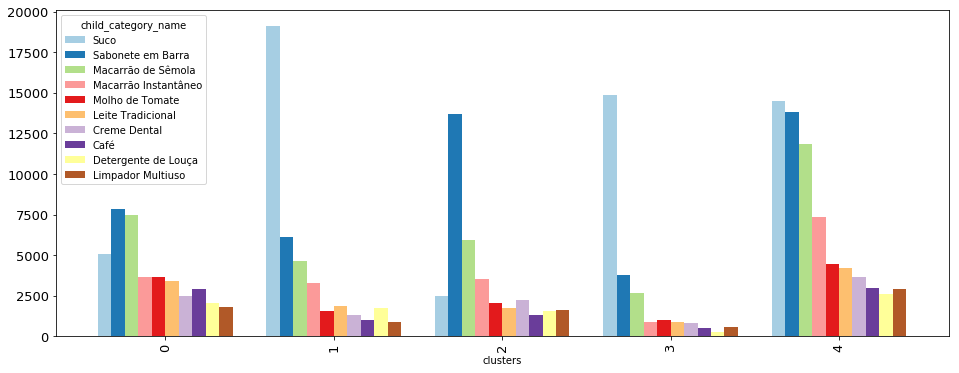

In [75]:
#plotagem do gráfico
group.plot.bar(figsize=(16,6), colormap='Paired', width=0.8 , fontsize=13)
plt.show()

In [ ]:
mais_ped = pd.pivot_table(pred, index=[''])

In [305]:
euclidean = pdist(pred, metric='euclidean')
euclidean = squareform(euclidean)
X = pd.DataFrame(euclidean)
X

,0,1,2,3,4,5,6,7,8,9,...,912,913,914,915,916,917,918,919,920,921
0,0.000000,125.586623,124.992000,131.464824,846.164287,199.391575,133.652535,116.494635,269.666461,105.023807,...,140.513345,158.634801,124.919974,142.832069,216.192044,656.667343,337.810598,130.938917,163.104261,138.834434
1,125.586623,0.000000,14.106736,20.518285,862.381586,201.432371,33.719431,38.431758,274.444894,59.799666,...,59.481089,126.154667,85.164547,66.204229,239.626793,673.413692,378.290893,57.140179,165.320900,45.310043
2,124.992000,14.106736,0.000000,23.237900,862.456376,201.866292,36.606010,40.224371,273.153803,57.939624,...,60.555759,125.602548,87.143560,68.322763,238.235178,675.075551,376.880618,59.933296,166.324983,51.361464
3,131.464824,20.518285,23.237900,0.000000,865.017341,208.187416,28.600699,45.978256,282.971730,71.042241,...,55.955339,133.760981,84.035707,64.699304,243.963112,678.911629,385.002597,55.389530,164.572173,46.000000
4,846.164287,862.381586,862.456376,865.017341,0.000000,858.942955,864.729437,858.344336,881.675677,856.820868,...,861.343137,859.997093,862.554926,862.673171,848.905766,546.938753,914.475806,818.501680,835.249065,866.146062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,656.667343,673.413692,675.075551,678.911629,546.938753,615.690669,672.365228,667.113933,661.322917,657.480038,...,668.577595,643.882753,668.774252,676.707470,630.565619,0.000000,709.704164,644.767400,628.008758,667.825576
918,337.810598,378.290893,376.880618,385.002597,914.475806,289.110705,386.107498,356.299032,360.521844,352.746368,...,387.659645,369.232989,324.519645,384.589391,208.760628,709.704164,0.000000,385.532100,272.306812,387.408054
919,130.938917,57.140179,59.933296,55.389530,818.501680,209.102846,60.183054,63.749510,284.655933,88.684835,...,75.066637,139.154590,90.939540,78.816242,237.528946,644.767400,385.532100,0.000000,158.656862,71.777434
920,163.104261,165.320900,166.324983,164.572173,835.249065,148.033780,165.420676,146.342065,286.986062,160.227963,...,171.659547,186.922444,107.888832,174.774140,138.397977,628.008758,272.306812,158.656862,0.000000,170.593083


In [286]:
#Esta função encontra k usuários semelhantes, dada a matriz user_id e de classificações M
# Observe que as semelhanças são as mesmas obtidas por meio do uso de pairwise_distances

def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[user_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    
    #flatten() Retorne uma cópia da matriz em uma dimensão
    similarities = 1-distances.flatten()
    print('{0} most similar users for User {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;

        else:
            print('{0}: User {1}, with similarity of {2}'.format(i, indices.flatten()[i]+1, similarities.flatten()[i]))
            
    return similarities,indices


In [289]:
similarities,indices = findksimilarusers(1,pred, metric='cosine')

10 most similar users for User 1:

1: User 768, with similarity of 0.8483650488771263
2: User 339, with similarity of 0.8218142375816565
3: User 270, with similarity of 0.777787264011743
4: User 359, with similarity of 0.7756710063309422
5: User 589, with similarity of 0.7747032317727599
6: User 55, with similarity of 0.7737059836082746
7: User 508, with similarity of 0.7677227026591061
8: User 549, with similarity of 0.7550514745411211
9: User 66, with similarity of 0.7501007183554558
10: User 815, with similarity of 0.7404554405681238


In [291]:
similarities,indices = findksimilarusers(1,pred, metric='correlation')

10 most similar users for User 1:

1: User 768, with similarity of 0.8487942656349922
2: User 339, with similarity of 0.8177254482699615
3: User 270, with similarity of 0.7784538385407904
4: User 359, with similarity of 0.7778118581067731
5: User 589, with similarity of 0.7765340539419928
6: User 55, with similarity of 0.7688420354904194
7: User 508, with similarity of 0.7611719507476631
8: User 549, with similarity of 0.7556993852357143
9: User 66, with similarity of 0.7443272538451174
10: User 815, with similarity of 0.7330032600704912


In [292]:
similarities,indices = findksimilarusers(1,pred, metric='euclidean')

10 most similar users for User 1:

1: User 55, with similarity of -84.0
2: User 66, with similarity of -86.65842800324451
3: User 153, with similarity of -92.16651759081692
4: User 623, with similarity of -93.68368391650169
5: User 461, with similarity of -94.29428104561154
6: User 815, with similarity of -98.20181449953424
7: User 508, with similarity of -99.46890066085126
8: User 34, with similarity of -102.59054010864119
9: User 10, with similarity of -104.02380682492898
10: User 335, with similarity of -104.40872829135166


In [296]:
# A função findksimilaritems usa o método NearestNeighbors, empregando similaridade de cosseno para encontrar k
# itens semelhantes ao item i. Collaborative Filtering.

def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]    
    ratings=ratings.T
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[item_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print('{0} most similar items for item {1}:\n'.format(k,item_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == item_id:
            continue;

        else:
            print('{0}: Item {1} :, with similarity of {2}'.format(i,indices.flatten()[i]+1, similarities.flatten()[i]))


    return similarities,indices

In [316]:
# Preciso alterar na lista para trazer o código e não o índice
similarities,indices=findksimilaritems(100,pred)

10 most similar items for item 100:

1: Item 339 :, with similarity of 0.7233407664930845
2: Item 74 :, with similarity of 0.6103974329047962
3: Item 157 :, with similarity of 0.5190400413847518
4: Item 217 :, with similarity of 0.47913832582357374
5: Item 123 :, with similarity of 0.46910975024256873
6: Item 91 :, with similarity of 0.41511618627952673
7: Item 58 :, with similarity of 0.4131716782842374
8: Item 107 :, with similarity of 0.39953733023871063
9: Item 76 :, with similarity of 0.3988471204408739
10: Item 181 :, with similarity of 0.39374873319094605


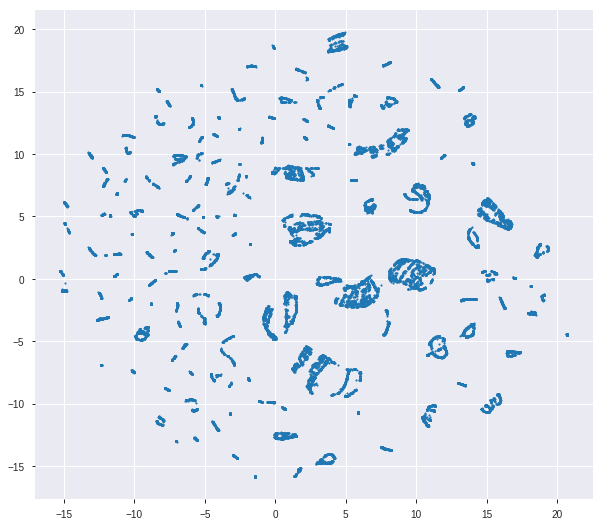

In [344]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(data)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

# Cada ponto neste gráfico é um produto. Como você pode ver, existem vários pequenos agrupamentos desses pontos
# de dados. É possível verificar que não possuimos muitos dados agrupados

In [147]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['customer_id'].isin(customers_train)]
validation_df = df[~df['customer_id'].isin(customers_train)]

In [150]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["customer_id"] == i]["child_category_id"].tolist()
    purchases_train.append(temp)

100%|██████████| 830/830 [00:00<00:00, 1146.49it/s]


In [314]:
# lista para capturar o histórico de compras dos clientes
purchases_val = []

# preencha a lista com os códigos do produto
for i in tqdm(validation_df['customer_id'].unique()):
    temp = validation_df[validation_df["customer_id"] == i]["child_category_name"].tolist()
    purchases_val.append(temp)
lista = np.array(purchases_val)
lista

100%|██████████| 92/92 [00:00<00:00, 988.72it/s]


array([list(['Guardanapo de Papel', 'Macarrão de Sêmola', 'Óleo de Soja', 'Molho de Tomate', 'Macarrão de Sêmola', 'Molho de Tomate', 'Guardanapo de Papel', 'Papel Higiênico', 'Macarrão de Sêmola', 'Refrigerante', 'Macarrão de Sêmola', 'Conserva', 'Papel Higiênico', 'Detergente de Louça', 'Macarrão de Sêmola', 'Macarrão de Sêmola', 'Inseticida', 'Desinfetante', 'Conserva', 'Macarrão de Sêmola', 'Filtro de Café', 'Filtro de Café', 'Macarrão de Sêmola', 'Filtro de Café', 'Refrigerante', 'Macarrão de Sêmola', 'Macarrão de Sêmola', 'Detergente de Louça', 'Refrigerante', 'Macarrão de Sêmola', 'Banha', 'Refrigerante', 'Macarrão de Sêmola', 'Adoçante', 'Detergente de Louça', 'Adoçante', 'Desinfetante', 'Refrigerante', 'Macarrão de Sêmola', 'Macarrão de Sêmola', 'Papel Higiênico', 'Molho de Tomate', 'Macarrão de Sêmola', 'Detergente de Louça', 'Creme de Leite', 'Detergente de Louça', 'Refrigerante', 'Macarrão de Sêmola', 'Macarrão de Sêmola', 'Desinfetante', 'Molho de Tomate', 'Óleo de Soja'])

In [308]:
purchases_val

[366]

In [156]:
products_dict[482]

['Farinha de Trigo']

In [168]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms   

In [169]:
similar_products([482])

AttributeError: 'LightFM' object has no attribute 'similar_by_vector'

In [125]:
# O fit_predict retorna os rotulos dos clusteres
pred["Cluster"] = kmeans.fit_predict(X)
pred

,0,1,2,3,4,5,6,7,8,9,...,337,338,339,340,341,342,343,344,345,Cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,8,0,0
1,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,2,4,0,0,0,0,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,0,0,15,7,0,0,0,0,0,0,...,0,0,0,2,1,1,0,3,0,1
918,0,0,1,0,0,0,0,2,0,0,...,0,5,0,6,0,0,0,12,0,2
919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
920,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,3,0,0


In [118]:
# quantidade de ítens vendidos por categoria Pai

pai = pd.crosstab(df['product_name'],df['parent_category_name'])
#pai.to_csv('../data/pai.csv')
pai

parent_category_name,Pai - Bazar,Pai - Bebidas Alcoólicas,Pai - Bebidas Não Alcoólicas,Pai - HPC,Pai - Limpeza / Descartáveis,Pai - Mercearia Básica,Pai - Perecíveis,Pai - Têxtil,Pai- Mercearia Complementar,Pai-Hortifruti
product_name,,,,,,,,,,
Abacaxi em Calda Predilecta Lata 400g,0,0,0,0,0,0,0,0,4,0
Absorvente Interno Mini Intimus Caixa 8 Unidades,0,0,0,0,29,0,0,0,0,0
Absorvente Interno Médio Intimus Caixa 8 Unidades,0,0,0,0,29,0,0,0,0,0
Absorvente Interno Médio Intimus Sport Caixa 8 Unidades,0,0,0,0,2,0,0,0,0,0
Absorvente Interno Super Intimus Caixa 8 Unidades,0,0,0,0,29,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
Óleo de Soja Soya Garrafa 900ml,0,0,0,0,0,389,0,0,0,0
Óleo de Soja Tipo 1 Liza Garrafa 900ml,0,0,0,0,0,1408,0,0,0,0
Óleo para Bebê Johnson's Baby Amêndoas Frasco 200ml,0,0,0,5,0,0,0,0,0,0


In [23]:
# função para saber todos os ítens comprados por um cliente

def customer_compra(id_client):
    #self.id_client = id_client
    result = df[df["customer_id"] == id_client]
    return result

customer_compra(7952)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
378,7718,7952,2666,Guardanapo de Papel Folha Simples Sorella 22cm...,386,Guardanapo de Papel,185,Pai - Limpeza / Descartáveis
379,4591,7952,3266,Macarrão de Sêmola com Ovos Gravata Renata Pac...,417,Macarrão de Sêmola,214,Pai - Mercearia Básica
380,7718,7952,3787,Óleo de Soja Tipo 1 Liza Garrafa 900ml,375,Óleo de Soja,214,Pai - Mercearia Básica
381,4591,7952,3632,Molho de Tomate Ervas Finas Predilecta Sachê 340g,241,Molho de Tomate,216,Pai- Mercearia Complementar
382,4591,7952,3266,Macarrão de Sêmola com Ovos Concha Renata Paco...,417,Macarrão de Sêmola,214,Pai - Mercearia Básica
383,4591,7952,3632,Molho de Tomate Tradicional Predilecta Sachê 340g,241,Molho de Tomate,216,Pai- Mercearia Complementar
384,7718,7952,2666,Guardanapo de Papel Folha Simples Sorella 22cm...,386,Guardanapo de Papel,185,Pai - Limpeza / Descartáveis
385,7718,7952,4000,Papel Higiênico Folha Dupla Neutro Duetto 30m ...,288,Papel Higiênico,185,Pai - Limpeza / Descartáveis
386,4591,7952,3266,Macarrão de Sêmola com Ovos Caracolino Renata ...,417,Macarrão de Sêmola,214,Pai - Mercearia Básica
387,4591,7952,4601,"Refrigerante Coca-Cola Garrafa 2,5l Embalagem ...",394,Refrigerante,180,Pai - Bebidas Não Alcoólicas


In [89]:
# função para saber informações sobre o Produto

def product_info(id_iten):
    result = df[df["int_itens_comp"] == id_iten]
    return result

product_info(2313)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
0,11260,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
147,9991,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
262,4270,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1287,9576,8086,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1288,9576,8086,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
...,...,...,...,...,...,...,...,...
372390,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
372393,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
372395,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
372396,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica


In [24]:
# função para saber todos os ítens por categoria Pai

def customer_compra(id_compra):
    result = df[df["parent_category_id"] == id_compra]
    return result

customer_compra(211)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
81,7471,7927,2720,Inseticida Aerossol Anti Aedes Aegypti SBP Noi...,244,Inseticida,211,Pai - Bazar
394,4591,7952,2720,Inseticida Aerossol Anti Aedes Aegypti SBP Noi...,244,Inseticida,211,Pai - Bazar
398,7718,7952,2436,Filtro de Papel Original Melitta 100 Caixa 30 ...,346,Filtro de Café,211,Pai - Bazar
399,7718,7952,2436,Filtro de Papel Original Melitta 102 Caixa 30 ...,346,Filtro de Café,211,Pai - Bazar
401,7718,7952,2436,Filtro de Papel Original Melitta 103 Caixa 30 ...,346,Filtro de Café,211,Pai - Bazar
...,...,...,...,...,...,...,...,...
372914,10093,61661,2722,Multi Inseticida Aerossol Óleo de Eucalipto SB...,244,Inseticida,211,Pai - Bazar
372915,10097,61661,2722,Multi Inseticida Aerossol Óleo de Eucalipto SB...,244,Inseticida,211,Pai - Bazar
372919,10097,61661,2722,Multi Inseticida Aerossol SBP Frasco 450ml Grá...,244,Inseticida,211,Pai - Bazar
372921,10097,61661,2722,Multi Inseticida Aerossol SBP Frasco 450ml Grá...,244,Inseticida,211,Pai - Bazar


In [45]:
# Criando uma tabela com usuario, id da categoria Pai e a quantidade de compras por usuário
data = pd.melt(df.set_index('customer_id')['child_category_id'].apply(pd.Series).reset_index(), id_vars=['customer_id'],
             value_name='child_category_id') \
    .dropna().drop(['variable'], axis=1) \
    .groupby(['customer_id', 'child_category_id']) \
    .agg({'child_category_id': 'count'}) \
    .rename(columns={'child_category_id': 'purchase_count'}) \
    .reset_index() \
    .rename(columns={'child_category_id': 'productId'})
data['productId'] = data['productId'].astype(np.int64)

In [46]:
data

,customer_id,productId,purchase_count
0,7927,181,15
1,7927,186,15
2,7927,190,12
3,7927,195,48
4,7927,224,6
...,...,...,...
27531,61661,349,40
27532,61661,350,4
27533,61661,357,14
27534,61661,361,5


In [30]:
df_matrix = pd.pivot_table(data, values='purchase_count', index='customer_id', columns='productId')
df_matrix

productId,180,182,185,191,211,214,216,275,282,526
customer_id,,,,,,,,,,
7927,15.0,76.0,42.0,108.0,1.0,85.0,51.0,NaN,NaN,NaN
7952,6.0,NaN,13.0,1.0,4.0,19.0,9.0,NaN,NaN,NaN
8037,NaN,NaN,2.0,8.0,3.0,22.0,6.0,NaN,NaN,NaN
8079,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
8086,841.0,175.0,139.0,54.0,12.0,275.0,256.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
61625,555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,NaN
61631,NaN,452.0,33.0,NaN,8.0,213.0,88.0,NaN,NaN,NaN
61640,61.0,16.0,8.0,NaN,NaN,24.0,40.0,NaN,NaN,NaN


In [44]:
# Substituindo NaN por 0

df_matrix[np.isnan(df_matrix)] = 0
df_matrix = pd.DataFrame(df_matrix)
df_matrix

productId,180,182,185,191,211,214,216,275,282,526
customer_id,,,,,,,,,,
7927,15.0,76.0,42.0,108.0,1.0,85.0,51.0,0.0,0.0,0.0
7952,6.0,0.0,13.0,1.0,4.0,19.0,9.0,0.0,0.0,0.0
8037,0.0,0.0,2.0,8.0,3.0,22.0,6.0,0.0,0.0,0.0
8079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
8086,841.0,175.0,139.0,54.0,12.0,275.0,256.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
61625,555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,0.0
61631,0.0,452.0,33.0,0.0,8.0,213.0,88.0,0.0,0.0,0.0
61640,61.0,16.0,8.0,0.0,0.0,24.0,40.0,0.0,0.0,0.0


In [51]:
# Normalizando o dataset

df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
df_matrix_norm

productId,180,182,185,191,211,214,216,275,282,526
customer_id,,,,,,,,,,
7927,0.011538,0.082073,0.073171,0.143617,0.017241,0.096263,0.045133,0.000000,0.000000,0.0
7952,0.004615,0.000000,0.022648,0.001330,0.068966,0.021518,0.007965,0.000000,0.000000,0.0
8037,0.000000,0.000000,0.003484,0.010638,0.051724,0.024915,0.005310,0.000000,0.000000,0.0
8079,0.000000,0.000000,0.000000,0.000000,0.000000,0.003398,0.000000,0.000000,0.000000,0.0
8086,0.646923,0.188985,0.242160,0.071809,0.206897,0.311438,0.226549,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
61625,0.426923,0.605832,1.000000,0.442819,0.172414,0.388448,0.686726,0.028571,0.009709,0.0
61631,0.000000,0.488121,0.057491,0.000000,0.137931,0.241223,0.077876,0.000000,0.000000,0.0
61640,0.046923,0.017279,0.013937,0.000000,0.000000,0.027180,0.035398,0.000000,0.000000,0.0


In [57]:
# Maxhine Learning
X = df_matrix.iloc[:,:].values
X

array([[ 15.,  76.,  42., ...,   0.,   0.,   0.],
       [  6.,   0.,  13., ...,   0.,   0.,   0.],
       [  0.,   0.,   2., ...,   0.,   0.,   0.],
       ...,
       [ 61.,  16.,   8., ...,   0.,   0.,   0.],
       [ 44., 272.,  30., ...,   0.,   0.,   0.],
       [  0.,   0.,  72., ...,   0.,   0.,   0.]])

In [61]:
kmeans = KMeans(n_clusters = 8, init = 'random')
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
kmeans.cluster_centers_

array([[ 6.11441441e+01,  2.10747748e+02,  9.79639640e+01,
         6.51711712e+01,  7.26126126e+00,  1.81495495e+02,
         1.83594595e+02,  2.16216216e-01,  2.36936937e+00,
         1.95156391e-18],
       [ 9.47750000e+02,  5.43250000e+02,  2.66375000e+02,
         2.88500000e+02,  1.52500000e+01,  4.85875000e+02,
         6.42125000e+02,  7.50000000e-01,  2.12500000e+00,
         0.00000000e+00],
       [ 1.03163065e+01,  1.36836935e+01,  8.11787819e+00,
         7.64833006e+00,  7.66208251e-01,  1.74970530e+01,
         1.91846758e+01,  3.53634578e-02,  4.04715128e-01,
         9.10729825e-18],
       [ 3.32411765e+01,  7.12588235e+01,  4.53352941e+01,
         3.53588235e+01,  3.74705882e+00,  9.73000000e+01,
         9.15470588e+01,  2.94117647e-01,  1.52352941e+00,
        -1.30104261e-18],
       [ 6.11464286e+02,  2.62357143e+02,  1.22321429e+02,
         6.15000000e+01,  7.32142857e+00,  2.50928571e+02,
         2.55250000e+02,  5.55111512e-17,  8.92857143e-01,
         3.

In [63]:
distance = kmeans.fit_transform(X)
distance

array([[ 348.87734626,   89.31086376,  142.89912276, ..., 1345.07331481,
         606.34853871,  550.3661559 ],
       [ 404.95346051,  148.72033063,   20.42297108, ..., 1452.40738852,
         723.53194152,  659.96538209],
       [ 410.57985505,  151.87874416,   23.86117013, ..., 1457.21545726,
         726.2571104 ,  662.72672012],
       ...,
       [ 344.88720362,  119.54067817,   54.76612563, ..., 1397.32597803,
         688.44911969,  624.59963621],
       [ 347.36157138,  217.37699939,  265.71338965, ..., 1297.04223353,
         525.15326372,  567.97808545],
       [ 417.07882253,  165.37387064,   73.14423092, ..., 1456.23906767,
         726.5731831 ,  668.06599391]])

In [69]:
labels = kmeans.labels_
labels

array([1, 2, 2, 2, 4, 3, 2, 2, 3, 1, 2, 2, 3, 2, 2, 1, 3, 3, 2, 2, 2, 3,
       1, 2, 2, 2, 3, 1, 1, 1, 3, 2, 2, 2, 3, 1, 2, 1, 1, 3, 2, 2, 1, 2,
       2, 3, 2, 3, 1, 3, 2, 7, 2, 3, 1, 2, 1, 1, 2, 2, 3, 2, 2, 3, 1, 1,
       2, 2, 2, 2, 0, 2, 3, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 6, 1, 2, 2,
       0, 1, 2, 2, 2, 1, 2, 2, 7, 1, 0, 1, 1, 2, 2, 2, 1, 2, 7, 2, 2, 2,
       1, 2, 3, 2, 2, 2, 1, 2, 1, 6, 2, 2, 2, 0, 2, 2, 2, 2, 3, 1, 3, 3,
       0, 2, 7, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2,
       3, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 5, 2, 1, 3, 2, 3, 2, 1, 2, 1,
       1, 2, 2, 2, 6, 2, 1, 2, 2, 2, 2, 2, 6, 1, 0, 2, 3, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 5, 2, 2, 4, 2, 2, 2,
       3, 2, 0, 2, 3, 3, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 6, 0, 2,
       2, 2, 1, 1, 4, 3, 0, 2, 4, 1, 2, 0, 3, 2, 3, 2, 2, 3, 3, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 1, 1, 2, 3, 2, 2, 2, 7, 2,
       2, 1, 2, 2, 0, 2, 6, 2, 3, 1, 2, 2, 1, 1, 5,

In [72]:
# Predizendo o cluster

data = [[15.0,76.0,42.0,108.0,1.0,85.0,51.0,0.0,0.0,0.0],[555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,0.0],[0.000000,0.000000,0.003484,0.010638,0.051724,0.024915,0.005310,0.000000,0.000000,0.0]]
kmeans.predict(data)

array([1, 5, 2], dtype=int32)

In [75]:
# O fit_predict retorna os rotulos dos clusteres
df_matrix["Cluster"] = kmeans.fit_predict(X)
df_matrix

productId,180,182,185,191,211,214,216,275,282,526,Cluster
customer_id,,,,,,,,,,,
7927,15.0,76.0,42.0,108.0,1.0,85.0,51.0,0.0,0.0,0.0,6
7952,6.0,0.0,13.0,1.0,4.0,19.0,9.0,0.0,0.0,0.0,1
8037,0.0,0.0,2.0,8.0,3.0,22.0,6.0,0.0,0.0,0.0,1
8079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1
8086,841.0,175.0,139.0,54.0,12.0,275.0,256.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...
61625,555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,0.0,0
61631,0.0,452.0,33.0,0.0,8.0,213.0,88.0,0.0,0.0,0.0,5
61640,61.0,16.0,8.0,0.0,0.0,24.0,40.0,0.0,0.0,0.0,1


In [306]:
plt.scatter(X[:, 0], X[:,-1], s = 100, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red',label = 'Centroids')
plt.title('Iris Clusters and Centroids')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend()

plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key